# BITS F464 : Machine Learning Assignment 2

Adit Rastogi <br>
2022A7PS1330H <br><br>
Deeptansh Gupta <br>
2022A7PS1336H <br><br>
Anirban Nayak <br>
2022A3PS0705H <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#html export
import plotly.io as pio
pio.renderers.default = 'notebook'

#pdf export
#!pip install Pyppeteer
#!pyppeteer-install

#!pip install tensorflow-decision-forests
#!pip install tensorflow

In [2]:
#please fill the dataset path as required
df_p1 = pd.read_csv("./MIMIC/221.csv")
df_p2 = pd.read_csv("./MIMIC/230.csv")

## Data Pre-processing For Both Patients

In [3]:
print(df_p1.shape)
df_p1.head()

(24999, 7)


,RESP,BP-S,BP-D,SpO2,HR,PULSE,Anomaly
0,28,81,120,98,74,73,0
1,29,81,120,98,74,73,0
2,30,81,120,98,74,73,0
3,30,81,120,99,74,73,0
4,29,81,120,99,73,73,0


In [4]:
print(df_p2.shape)
df_p2.head()

(25000, 7)


,RESP,BP-S,BP-D,SpO2,HR,PULSE,Anomaly
0,15,54,73,97,72,71,0
1,15,54,73,97,72,71,0
2,15,54,73,97,72,71,0
3,15,54,73,97,72,71,0
4,15,55,74,97,72,71,0


#### Creating a Describe Function

In [5]:
def describe(df):
    describe_df = df.describe()

    # Calculating median and standard deviation
    median = df.median(numeric_only=True)
    std_dev = df.std(numeric_only=True)

    # Appendind median and standard deviation to describe_df
    describe_df.loc['median'] = median
    describe_df.loc['std'] = std_dev

    # Removing 25%, 50%, and 75% statistics
    describe_df = describe_df.drop(['25%', '50%', '75%'])

    # Reordering the rows
    describe_df = describe_df.loc[['count', 'mean', 'median', 'std', 'min', 'max']]

    # Styling
    styled_summary = (describe_df.style
                      .format("{:.2f}")  # Format numbers to 2 decimal places
                      .background_gradient(cmap='coolwarm')  # Add color gradient
                      .set_table_styles([{'selector': 'thead th', 'props': [('background-color', '#404040'), ('color', 'white')]}])  # Style headers
                      )

    display(styled_summary)
    return 

In [6]:
print("Patient 1")
describe(df_p1)
print("Patient 2")
describe(df_p2)

Patient 1


,RESP,BP-S,BP-D,SpO2,HR,PULSE,Anomaly
count,24999.00,24999.00,24999.00,24999.00,24999.00,24999.00,24999.00
mean,23.76,83.89,121.41,99.04,88.56,87.98,0.07
median,23.00,83.00,121.00,99.00,88.00,88.00,0.00
std,4.49,4.75,8.97,1.30,9.59,9.22,0.25
min,0.00,66.00,88.00,0.00,0.00,0.00,0.00
max,42.00,127.00,170.00,100.00,120.00,119.00,1.00


Patient 2


,RESP,BP-S,BP-D,SpO2,HR,PULSE,Anomaly
count,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00
mean,17.62,53.97,73.92,94.53,77.00,76.18,0.03
median,17.00,54.00,73.00,94.00,76.00,75.00,0.00
std,3.56,7.75,10.04,2.14,6.61,5.95,0.17
min,0.00,37.00,52.00,81.00,0.00,54.00,0.00
max,42.00,211.00,217.00,99.00,131.00,128.00,1.00


### Finding columns with missing values

In [7]:
def missing(df):
    missing_values_per_column = df.isnull().sum()
    columns_with_missing_values = missing_values_per_column[missing_values_per_column > 0]
    print("Columns with missing values:\n", columns_with_missing_values)
    return 

In [8]:
print("Patient 1")
missing(df_p1)
print("Patient 2")
missing(df_p2)

Patient 1
Columns with missing values:
 Series([], dtype: int64)
Patient 2
Columns with missing values:
 Series([], dtype: int64)


- There are no Missing Values in Both the DataSets

### Checking for Duplicates in the Data Frame

In [9]:
def check_dup(df):
    duplicates = df.duplicated()
    num_duplicates = duplicates.sum()

    print("Number of duplicate rows:", num_duplicates)
    if num_duplicates > 0:
        print("\nDuplicate rows:")
        print(df[duplicates])
    return


In [10]:
print("Patient 1")
check_dup(df_p1)
print("Patient 2")
check_dup(df_p2)

Patient 1
Number of duplicate rows: 9445

Duplicate rows:
       RESP  BP-S  BP-D  SpO2  HR  PULSE  Anomaly
6        30    81   120    98  73     73        0
7        30    81   120    98  73     73        0
9        26    81   120    98  74     74        0
13       31    81   120    98  74     75        0
17       27    81   121    98  76     75        0
...     ...   ...   ...   ...  ..    ...      ...
24959    24    78   113   100  91     91        0
24960    24    78   113   100  91     91        0
24965    24    81   117   100  94     94        0
24967    24    81   117   100  95     94        0
24975    24    82   119   100  95     96        0

[9445 rows x 7 columns]
Patient 2
Number of duplicate rows: 16551

Duplicate rows:
       RESP  BP-S  BP-D  SpO2  HR  PULSE  Anomaly
1        15    54    73    97  72     71        0
2        15    54    73    97  72     71        0
3        15    54    73    97  72     71        0
5        15    55    74    97  72     71        0
7       

- There are 9445 duplicate rows in Patient 1
- There are 16551 duplicates in Patient 2

We are not dropping the duplicates because the duplicate values could be usefull in the following analysis

### Normalization

- Algorithms like Decision Trees, Random Forests, and Gradient Boosting are not sensitive to the scale of features. These algorithms split data based on feature values rather than calculating distances or optimizing gradients, so normalization is generally not required.

## ID3 Algorithm (Patient 1)
### Using Scikit-Learn's DecisionTreeClassifier

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:
X = df_p1.drop(columns=['Anomaly'])
y = df_p1['Anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
ID3_model = DecisionTreeClassifier(criterion='entropy', random_state=42);
ID3_model.fit(X_train, y_train)
predictions = ID3_model.predict(X_test)
score = accuracy_score(y_test, predictions)
print(f"Accuracy of the ID3 model: {score:.4f}")

Accuracy of the ID3 model: 0.9956


### Writing Custom Implementation

In [14]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

class ID3:
    def __init__(self):
        self.tree = None

    def entropy(self, y):
        """Calculating the entropy of the labels (target variable)."""
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def information_gain(self, X_column, y, threshold):
        """Calculating information gain for a feature split on the threshold."""
        # Split data
        left_idxs = X_column <= threshold
        right_idxs = X_column > threshold
        
        # Calculate the weighted average entropy after the split
        left_entropy = self.entropy(y[left_idxs])
        right_entropy = self.entropy(y[right_idxs])
        n, n_left, n_right = len(y), len(y[left_idxs]), len(y[right_idxs])
        weighted_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
        
        # Information gain is the reduction in entropy
        return self.entropy(y) - weighted_entropy

    def best_split(self, X, y):
        """Find the best feature and threshold to split on."""
        best_gain = -1
        split_idx, split_threshold = None, None
        
        for i in range(X.shape[1]):  # iterate over features
            X_column = X[:, i]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self.information_gain(X_column, y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = i
                    split_threshold = threshold
                    
        return split_idx, split_threshold

    def build_tree(self, X, y, features, depth=0, max_depth=None):
        """Recursively building the decision tree."""
        # Stopping conditions
        if len(np.unique(y)) == 1:  # pure split (all labels are the same)
            return y[0]
        
        if len(features) == 0 or (max_depth is not None and depth >= max_depth):  # no features left or max depth reached
            return Counter(y).most_common(1)[0][0]  # return majority class
        
        # Find the best split
        split_idx, split_threshold = self.best_split(X, y)
        if split_idx is None:
            return Counter(y).most_common(1)[0][0]  # return majority class
        
        # Partition data
        left_idxs = X[:, split_idx] <= split_threshold
        right_idxs = X[:, split_idx] > split_threshold
        left_subtree = self.build_tree(X[left_idxs], y[left_idxs], features, depth + 1, max_depth)
        right_subtree = self.build_tree(X[right_idxs], y[right_idxs], features, depth + 1, max_depth)
        
        # Return the tree structure as a dictionary
        return {
            'feature': features[split_idx],
            'threshold': split_threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def fit(self, X, y, max_depth=None):
        """Fit the ID3 decision tree to the training data."""
        self.features = [f"Feature {i}" for i in range(X.shape[1])]  # use default names for features
        self.tree = self.build_tree(X, y, self.features, max_depth=max_depth)

    def predict_sample(self, sample, tree):
        """Predict the class for a single sample using the decision tree."""
        if not isinstance(tree, dict):  # if it's a leaf node
            return tree
        
        feature = tree['feature']
        threshold = tree['threshold']
        
        if sample[self.features.index(feature)] <= threshold:
            return self.predict_sample(sample, tree['left'])
        else:
            return self.predict_sample(sample, tree['right'])

    def predict(self, X):
        """Predict the class for each sample in the dataset."""
        return np.array([self.predict_sample(x, self.tree) for x in X])

In [15]:
X = df_p1.drop(columns=['Anomaly'])
y = df_p1['Anomaly']

# Converting DataFrame to NumPy arrays 
X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = ID3()
model.fit(X_train, y_train, max_depth=3)

#printing the decision tree
print("Decision Tree:", model.tree)


predictions = model.predict(X_test)


accuracy = accuracy_score(y_test, predictions)

print("Predictions:", predictions)
print("Actual labels:", y_test)
print("Accuracy:", accuracy)


Decision Tree: {'feature': 'Feature 4', 'threshold': 101, 'left': {'feature': 'Feature 2', 'threshold': 134, 'left': {'feature': 'Feature 2', 'threshold': 106, 'left': 1, 'right': 0}, 'right': {'feature': 'Feature 4', 'threshold': 94, 'left': 0, 'right': 1}}, 'right': {'feature': 'Feature 3', 'threshold': 98, 'left': {'feature': 'Feature 2', 'threshold': 106, 'left': 1, 'right': 0}, 'right': {'feature': 'Feature 2', 'threshold': 111, 'left': 1, 'right': 1}}}
Predictions: [0 0 0 ... 0 0 0]
Actual labels: [0 0 0 ... 0 0 0]
Accuracy: 0.9766


- Accuracy of custom implementation of ID3 algorithm is 0.9766

## CART Algorithm (Patient 2)
### Using Scikit-Learn's DecisionTreeClassifier

In [16]:
X = df_p2.drop(columns=['Anomaly'])
y = df_p2['Anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
CART_model = DecisionTreeClassifier(criterion='gini', random_state=42);
CART_model.fit(X_train, y_train)
predictions = CART_model.predict(X_test)
score = accuracy_score(y_test, predictions)
print(f"Accuracy of the CART model: {score:.4f}")

Accuracy of the CART model: 0.9946


### Using Tensorflow's CartModel

In [18]:
import tensorflow_decision_forests as tfdf

train_data, test_data = train_test_split(df_p2, test_size=0.2, random_state=42)

# Convert the training and testing sets to TensorFlow datasets
train_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label="Anomaly")
test_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label="Anomaly")


CART_tensorflow_model = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)
CART_tensorflow_model.fit(train_tf_dataset)

test_features = test_data.drop(columns=['Anomaly'])
test_labels = test_data['Anomaly']


predictions = CART_tensorflow_model.predict(test_tf_dataset)

# Convert predictions to a binary form (0 or 1)
predicted_classes = predictions.argmax(axis=1) 

accuracy = accuracy_score(test_labels, predicted_classes)

Use /var/folders/tm/q2tst96s0ds41f5mprd5bzb00000gn/T/tmp8ewjq67a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.555762. Found 20000 examples.
Training model...
Model trained in 0:00:00.055141
Compiling model...


I0000 00:00:1725811162.170646 3027782 kernel.cc:774] Start Yggdrasil model training
I0000 00:00:1725811162.171318 3027782 kernel.cc:775] Collect training examples
I0000 00:00:1725811162.171325 3027782 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1725811162.172400 3027782 kernel.cc:394] Number of batches: 20
I0000 00:00:1725811162.172407 3027782 kernel.cc:395] Number of examples: 20000
I0000 00:00:1725811162.174178 3027782 kernel.cc:794] Training dataset:
Number of records: 20000
Number of columns: 7

Number of columns by type:
	NUMERICAL: 6 (85.7143%)
	CATEGORICAL: 1 (14.2857%)

Columns:

NUMERICAL: 6 (85.7143%)
	0: "BP-D" NUMERICAL mean:

Model compiled.
5/5 [==============================] - 0s 3ms/step


In [19]:
print(CART_tensorflow_model.summary())
print(f"Accuracy of CART algorithm using TensorFlow is : {accuracy}")

Model: "cart_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	BP-D
	BP-S
	HR
	PULSE
	RESP
	SpO2

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "SpO2"  1.000000 ################
    2.    "HR"  0.297297 ##
    3.  "RESP"  0.237838 #
    4.  "BP-S"  0.178862 
    5.  "BP-D"  0.172549 
    6. "PULSE"  0.137072 

Variable Importance: NUM_AS_ROOT:
    1. "SpO2"  1.000000 

Variable Importance: NUM_NODES:
    1.    "HR"  9.000000 ################
    2.  "BP-D"  8.000000 ############
    3.  "RESP"  8.000000 ############
    4.  "BP-S"  7.000000 ########
    5. "PULSE"  6.000000 ####
    6.  "SpO2"  5.000000 

Variable Importance: SUM_SCORE:
    1. 

## Random Forest Algorithm on the Patient-1

In [20]:
train_data, test_data = train_test_split(df_p1, test_size=0.2, random_state=42)


train_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label="Anomaly")
test_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label="Anomaly")

RF_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
RF_model.fit(train_tf_dataset)

#Evaluating the Model
evaluation = RF_model.evaluate(test_tf_dataset) 
print(f"Evaluation results (Test Set): {evaluation}")

predictions = RF_model.predict(test_tf_dataset)
predicted_classes = predictions.argmax(axis=1)
test_labels = test_data['Anomaly']

accuracy = accuracy_score(test_labels, predicted_classes)

Use /var/folders/tm/q2tst96s0ds41f5mprd5bzb00000gn/T/tmp59benmyv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.159202. Found 19999 examples.
Training model...


I0000 00:00:1725811163.063297 3027782 kernel.cc:774] Start Yggdrasil model training
I0000 00:00:1725811163.063312 3027782 kernel.cc:775] Collect training examples
I0000 00:00:1725811163.063318 3027782 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1725811163.063356 3027782 kernel.cc:394] Number of batches: 20
I0000 00:00:1725811163.063361 3027782 kernel.cc:395] Number of examples: 19999
I0000 00:00:1725811163.064958 3027782 kernel.cc:794] Training dataset:
Number of records: 19999
Number of columns: 7

Number of columns by type:
	NUMERICAL: 6 (85.7143%)
	CATEGORICAL: 1 (14.2857%)

Columns:

NUMERICAL: 6 (85.7143%)
	0: "BP-D" NUMERICAL mean:

Model trained in 0:00:01.041755
Compiling model...


I0000 00:00:1725811163.915845 3028222 kernel.cc:920] Export model in log directory: /var/folders/tm/q2tst96s0ds41f5mprd5bzb00000gn/T/tmp59benmyv with prefix 35d55ffed5ee47d6
I0000 00:00:1725811163.956341 3028222 kernel.cc:938] Save model in resources
I0000 00:00:1725811163.957288 3027782 abstract_model.cc:833] Model self evaluation:
Number of predictions (without weights): 19999
Number of predictions (with weights): 19999
Task: CLASSIFICATION
Label: __LABEL

Accuracy: 0.99415  CI95[W][0.993182 0.995008]
LogLoss: : 0.0193167
ErrorRate: : 0.00585032

Default Accuracy: : 0.933997
Default LogLoss: : 0.243176
Default ErrorRate: : 0.0660033

Confusion Table:
truth\prediction
       1     2
1  18645    34
2     83  1237
Total: 19999


2024-09-08 21:29:23.973649: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1234] Loading model from path /var/folders/tm/q2tst96s0ds41f5mprd5bzb00000gn/T/tmp59benmyv/model/ with prefix 35d55ffed5ee47d6
I0000 00:00:1725811164.094013 3027782 deci

Model compiled.
5/5 [==============================] - 0s 15ms/step - loss: 0.0000e+00
Evaluation results (Test Set): 0.0
5/5 [==============================] - 0s 14ms/step


In [21]:
print(RF_model.summary())
print(f"Accuracy in Random Forest Algorithm on Patient 1 is: {accuracy}")

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	BP-D
	BP-S
	HR
	PULSE
	RESP
	SpO2

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.    "HR"  0.487938 ################
    2.  "BP-D"  0.381304 ###########
    3. "PULSE"  0.185546 ##
    4.  "BP-S"  0.185395 ##
    5.  "SpO2"  0.135670 
    6.  "RESP"  0.130081 

Variable Importance: NUM_AS_ROOT:
    1.    "HR" 202.000000 ################
    2. "PULSE" 72.000000 ####
    3.  "BP-D" 26.000000 

Variable Importance: NUM_NODES:
    1.  "BP-D" 6437.000000 ################
    2.  "BP-S" 5832.000000 #############
    3.  "RESP" 5752.000000 #############
    4.    "HR" 5516.000000 

### Visualizing The First Tree

In [22]:
# *** WORKS ONLY IN GOOGLE COLAB ***
import tensorflow_decision_forests as tfdf
tfdf.model_plotter.plot_model_in_colab(RF_model, tree_idx=0, max_depth=3)

### Scatter Plot for Patient 1

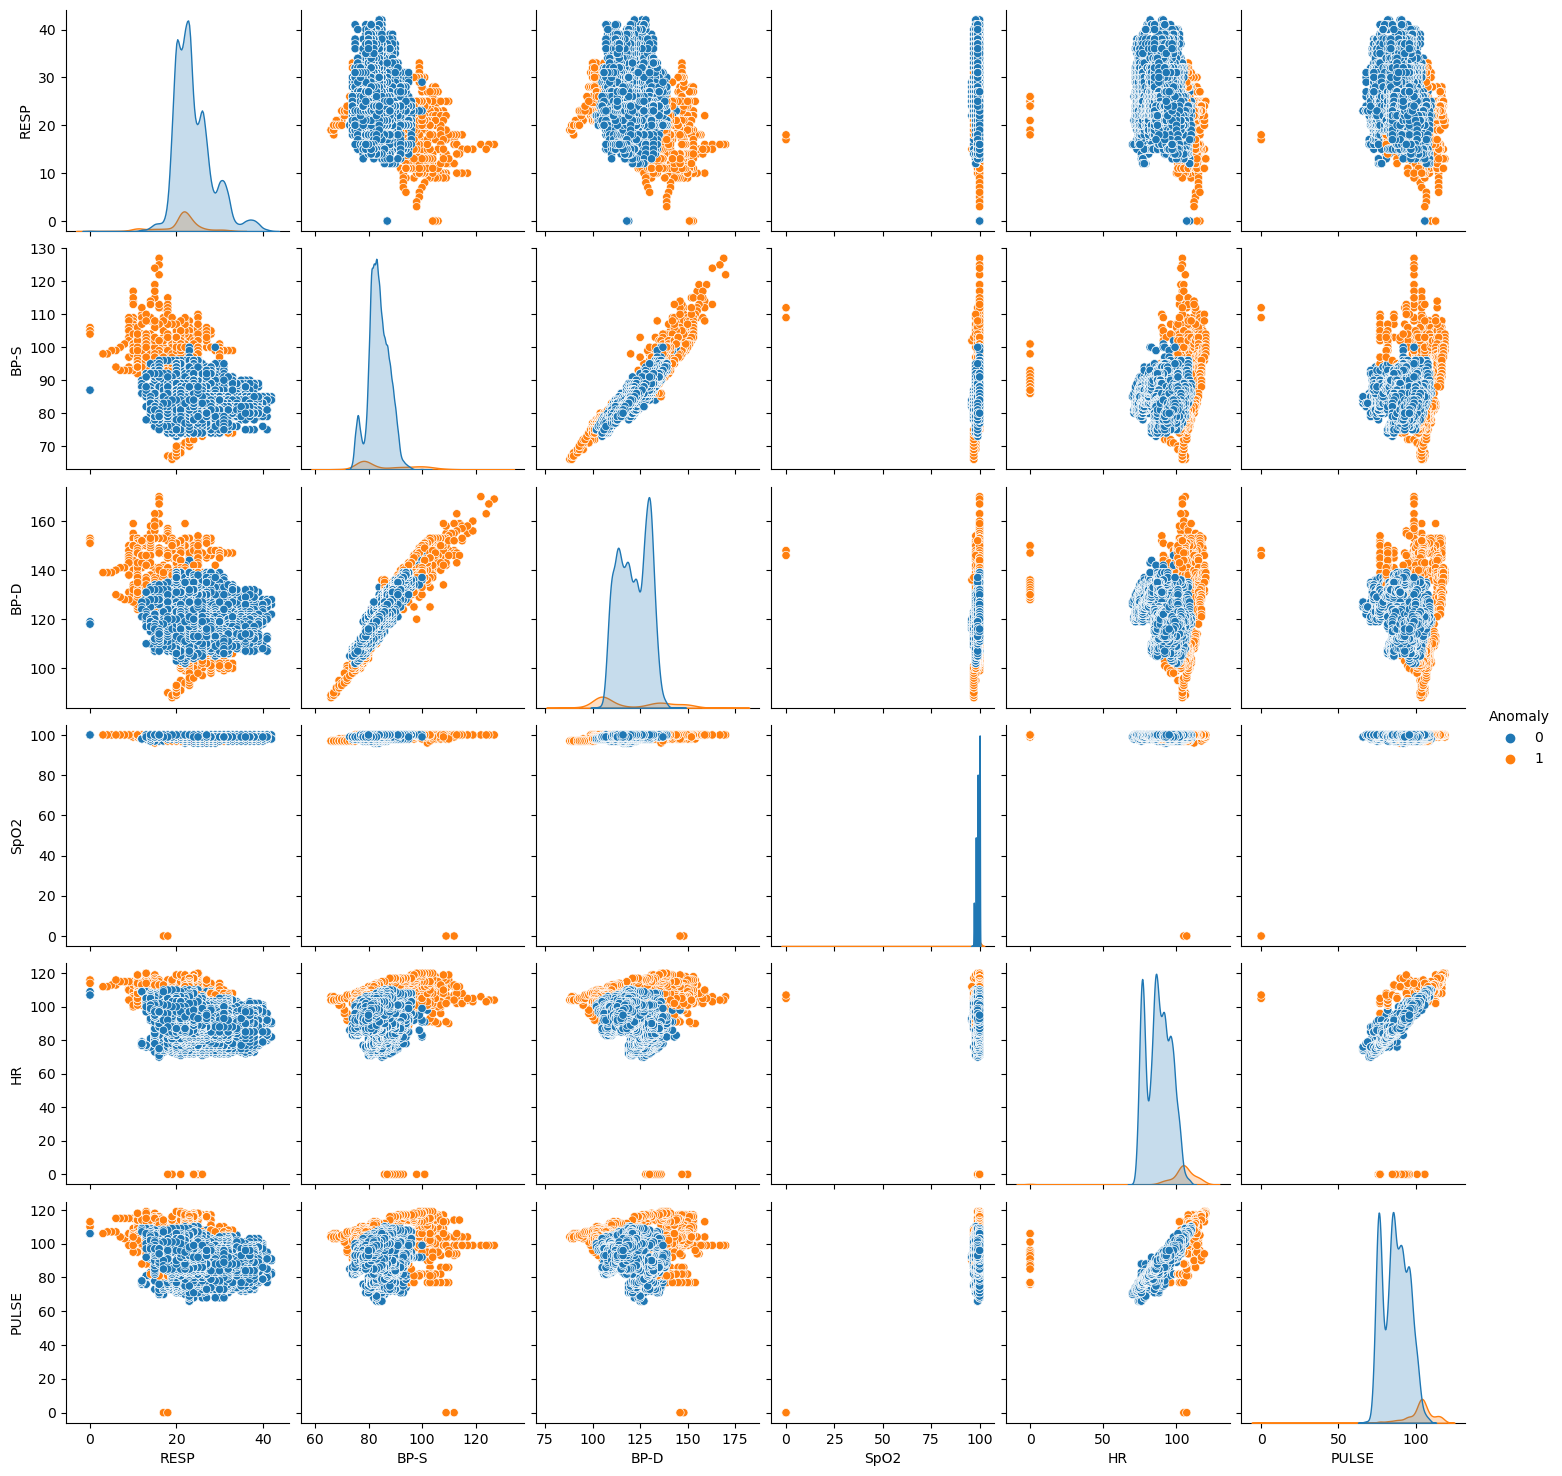

In [23]:
sns.pairplot(df_p1, hue="Anomaly")
plt.show()


### Scatter Plot for Patient 2

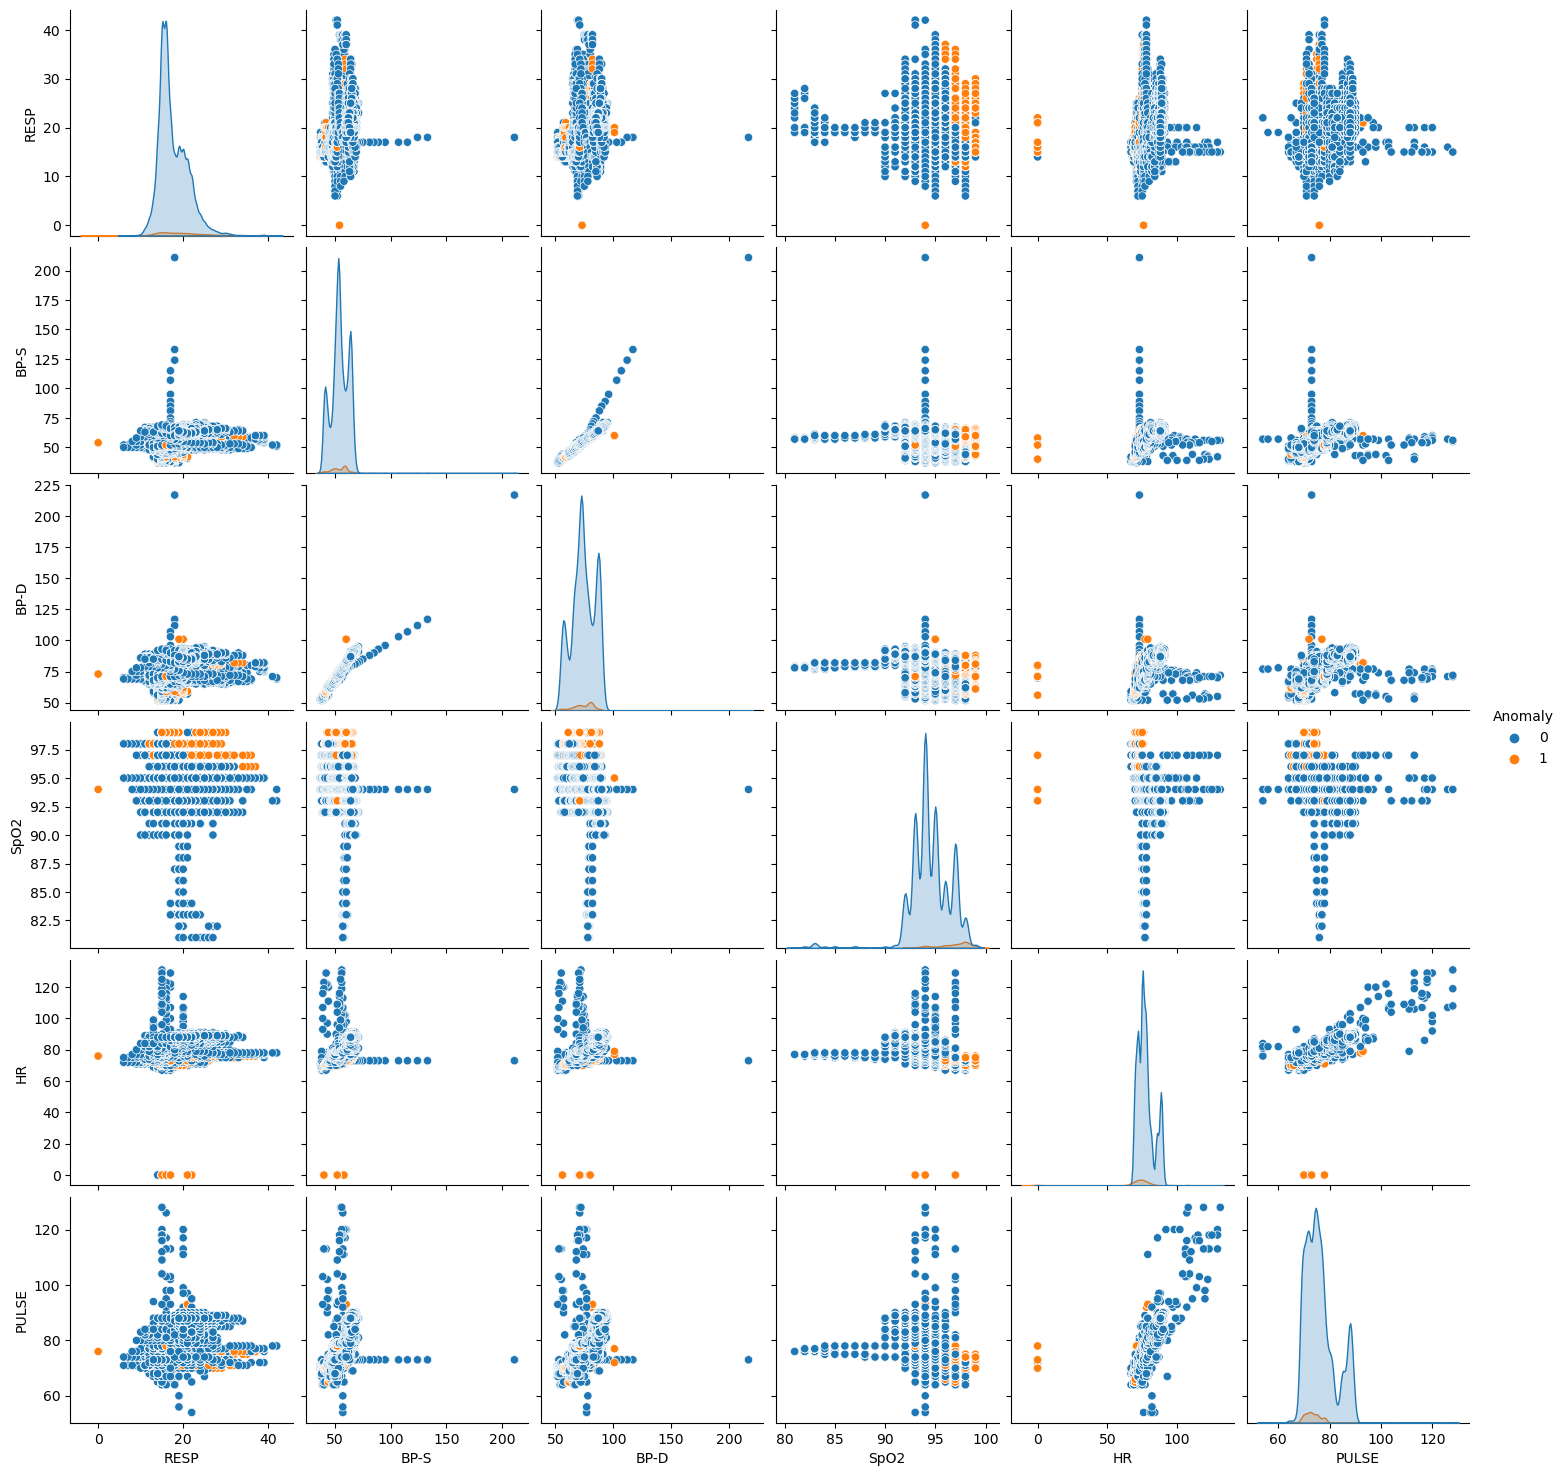

In [24]:
sns.pairplot(df_p2, hue="Anomaly")
plt.show()

## Gradient Boosted Decision Trees on Patient 2

In [25]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV

In [26]:
X = df_p2.drop(columns=['Anomaly'])
y = df_p2['Anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
GBDT_model = GradientBoostingClassifier()

space_search = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

GBDT_grid = GridSearchCV(estimator=GBDT_model, param_grid=space_search, cv=5, scoring='accuracy')
GBDT_grid.fit(X_train, y_train)
GBDT_best = GBDT_grid.best_estimator_

y_pred_GBDT = GBDT_best.predict(X_test)
y_proba_GBDT = GBDT_best.predict_proba(X_test)

best_params = GBDT_grid.best_params_

print("Best Hyperparameters for GBDT:")
for param, value in best_params.items():
    print(f"{param}: {value}")
    
accuracy_GBDT = accuracy_score(y_test, y_pred_GBDT)
log_loss_GBDT = log_loss(y_test, y_proba_GBDT)

print("Gradient Boosting Classifier - Accuracy:", accuracy_GBDT)
print("Gradient Boosting Classifier - Log Loss:", log_loss_GBDT)

### Random Forest Classifier for Comparison ###
# Instantiate the model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
RF_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = RF_model.predict(X_test)
y_proba_rf = RF_model.predict_proba(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
log_loss_rf = log_loss(y_test, y_proba_rf)

print("\nRandom Forest Classifier - Accuracy:", accuracy_rf)
print("Random Forest Classifier - Log Loss:", log_loss_rf)

Best Hyperparameters for GBDT:
learning_rate: 0.1
max_depth: 5
n_estimators: 200
subsample: 1.0
Gradient Boosting Classifier - Accuracy: 0.9956
Gradient Boosting Classifier - Log Loss: 0.014682060215965537

Random Forest Classifier - Accuracy: 0.9962
Random Forest Classifier - Log Loss: 0.02246845257406677


#### Gradient Boosting Decision Tree Plot : 

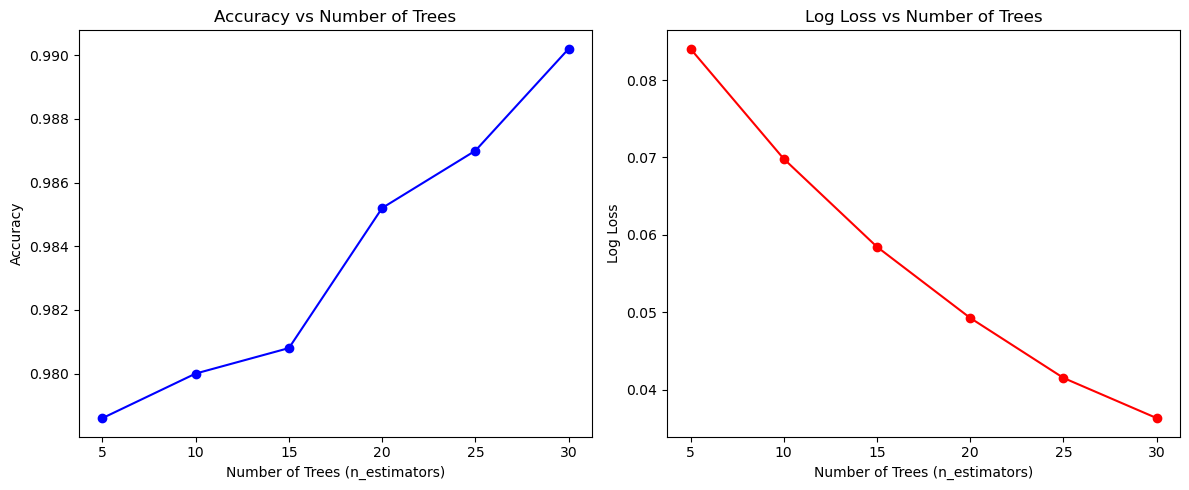


Gradient Boosting Classifier - CV Accuracy: 0.9974500000000001
Random Forest Classifier - CV Accuracy: 0.9971


In [28]:
accuracy_list = []
log_loss_list = []

# Define a range of 'n_estimators' to analyze its impact on accuracy and log loss
n_estimators_range = [5, 10, 15, 20, 25, 30]

# Loop over different values for n_estimators, keeping other hyperparameters constant
for n in n_estimators_range:
    # Use the best hyperparameters from GridSearchCV and modify n_estimators
    gbdt = GradientBoostingClassifier(
        n_estimators=n, 
        learning_rate=best_params['learning_rate'], 
        max_depth=best_params['max_depth'],
        subsample=best_params['subsample'],
        random_state=42
    )
    
    # Train the model
    gbdt.fit(X_train, y_train)
    
    # Make predictions
    y_pred = gbdt.predict(X_test)
    y_proba = gbdt.predict_proba(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    
    # Calculate log loss
    loss = log_loss(y_test, y_proba)
    log_loss_list.append(loss)

# Plot Accuracy vs Number of Trees
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy vs. Number of Trees
plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, accuracy_list, marker='o', color='b')
plt.title("Accuracy vs Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")

# Subplot 2: Log Loss vs. Number of Trees
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, log_loss_list, marker='o', color='r')
plt.title("Log Loss vs Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Log Loss")

# Show the plots
plt.tight_layout()
plt.show()

### Cross-Validation for both models ###
cv_accuracy_gbdt = cross_val_score(GBDT_best, X_train, y_train, cv=5, scoring='accuracy').mean()
cv_accuracy_rf = cross_val_score(RF_model, X_train, y_train, cv=5, scoring='accuracy').mean()

print("\nGradient Boosting Classifier - CV Accuracy:", cv_accuracy_gbdt)
print("Random Forest Classifier - CV Accuracy:", cv_accuracy_rf)

- The Cross-Validation (CV) Accuracy comparison evaluates how well different models perform across multiple subsets of the training data, providing a more robust understanding of the model's ability to generalize to unseen data.
- On Analysing the CV Accuracy, Gradient Boosting Classifier performs slightly better than Random Forest Classifier

In [29]:
# Manually defined hyperparameter values
n_estimators = 150
learning_rate = 0.05
max_depth = 4
subsample = 0.8
min_samples_split = 5
min_samples_leaf = 2

gbdt_manual = GradientBoostingClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)


gbdt_manual.fit(X_train, y_train)


y_pred_manual = gbdt_manual.predict(X_test)
accuracy_manual = accuracy_score(y_test, y_pred_manual)

print(f"Accuracy of GBDT with manual hyperparameters: {accuracy_manual:.4f}")
print("Accuracy of GBDT with tuning of hyperparameters:", accuracy_GBDT)


Accuracy of GBDT with manual hyperparameters: 0.9934
Accuracy of GBDT with tuning of hyperparameters: 0.9956


- We can clearly see without tuning of hyperparameters we are getting accuracy of 0.9934 where as with tuning the hyperparameters we are getting an accuracy of 0.9956 which is slightly higher.

### Feature Importance

In [30]:
feature_importances = GBDT_best.feature_importances_
feature_names = ['RESP', 'BP-S', 'BP-D', 'SpO2', 'HR', 'PULSE']
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance (optional)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nGradient Boosting Decision Trees:\n")
print(importance_df)


Gradient Boosting Decision Trees:

  Feature  Importance
4      HR    0.266682
2    BP-D    0.194518
3    SpO2    0.163694
0    RESP    0.147377
1    BP-S    0.127341
5   PULSE    0.100388


In [31]:
feature_importances = RF_model.feature_importances_
feature_names = ['RESP', 'BP-S', 'BP-D', 'SpO2', 'HR', 'PULSE']
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance (optional)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nRandom Forest:\n")
print(importance_df)


Random Forest:

  Feature  Importance
4      HR    0.212286
0    RESP    0.184256
3    SpO2    0.169476
2    BP-D    0.158350
5   PULSE    0.140140
1    BP-S    0.135492
